In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms, utils
from copy import deepcopy
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
from os.path import join as oj
import sys
import acd
from tqdm import tqdm
import pickle as pkl
import torchvision
import models
import time
from functools import partial
sys.path.append('..')
sys.path.append('../trim')
sys.path.append('../trim/convolutional_sparse_coding')
# plt.style.use('dark_background')
from visualize import *
from data import *
from style import *
data_path = './cosmo'
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# import modules
from acd_wooseok.acd.scores import cd
from funcs import *
from matfac import *

# load dataset and model

In [9]:
# params
img_size = 256
class_num = 1

In [10]:
# cosmo dataset
transformer = transforms.Compose([ToTensor()])
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  
                              oj(data_path, 'z1_256'),
                              transform=transformer)

# dataloader
data_loader = torch.utils.data.DataLoader(mnu_dataset, batch_size=64, shuffle=False, num_workers=4)

# load model
model = models.load_model(model_name='resnet18', device=device, data_path=data_path).to(device)

# conv sparse coding

In [11]:
# set hyper-params and variables
n_components = 6
kernel_size = 7
n_dim = kernel_size + (img_size-1)

csc = Conv_SpCoding(kernel_size, n_dim, n_components).to(device)
# load checkpoint
# csc.load_state_dict(torch.load('./model/csc_maxCD_0.pth'))

# reg-parameter
lamb = 3.0e-4

# losses
n_inner_c = 10
n_inner_w = 100
losses = [1000]

# set optimizer
lr_c = 0.1
lr_w = 0.5

In [12]:
X = iter(data_loader).next()['image'].to(device)
n_batch = len(X)

In [13]:
num_epochs = 50
for epoch in range(num_epochs):
    # initialize act maps
    csc.init_maps(n_batch)
    csc.to(device)
    optimizer = csc_optimizer(csc, lr_c, lr_w, lamb)
    
    # update weight
    unfreeze(csc, param='map')
    # inner loop
    for i in range(n_inner_w):
        optimizer.zero_grad() # clear the old gradients
        # comp loss
        X_ = csc()
        loss = torch.norm(X-X_)**2/(2*n_batch)    
        # backward
        loss.backward()
        # update step
        optimizer.step(1)    

    reg_loss = L1Reg_loss(csc, X, lamb)
    losses.append(reg_loss)      

    # update dict
    unfreeze(csc, param='dict', obj_type='csc')
    # inner loop
    for i in range(n_inner_c):
        optimizer.zero_grad() # clear the old gradients
        # comp loss
        X_ = csc()
        loss = torch.norm(X-X_)**2/(2*n_batch)
        # backward
        loss.backward()
        # update step
        optimizer.step(0)    

    reg_loss = L1Reg_loss(csc, X, lamb)
    losses.append(reg_loss)             

    if epoch % 1 == 0:
        # recon-error, nnz
        err = torch.norm(X-X_).data.item() / torch.norm(X).data.item() 
        nnz = 0
        for feature_map in csc.maps:
            nnz += np.count_nonzero(feature_map.data.cpu().numpy())
        nnz_W = nnz/(n_dim*n_dim*n_components*n_batch)

        print('\rTrain Epoch: {} [({:.0f}%)]\tError: {:.6f}\tLoss: [{:.6f}, {:.6f}, {:.6f}]\tNNZ: {:.6f}%'.format(
            epoch, 100. * epoch / num_epochs, err, losses[-3], losses[-2], losses[-1], 100. * nnz_W), end='')         

Train Epoch: 49 [(98%)]	Error: 0.340551	Loss: [3.297219, 3.297133, 3.294864]	NNZ: 10.930823%

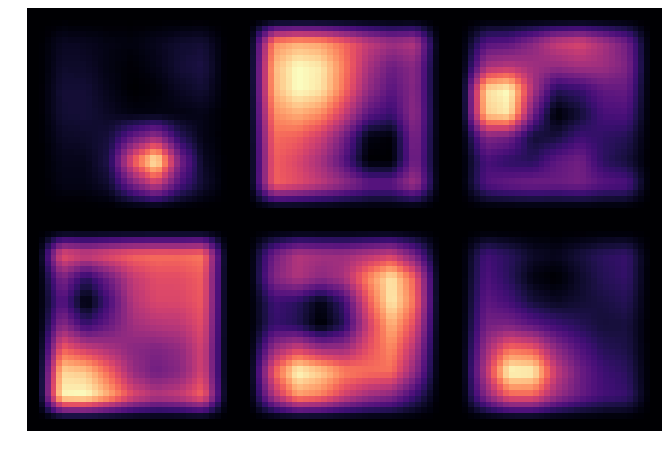

In [15]:
from skimage.transform import rescale

n_row = 2
n_col = 3
Nimages = len(csc.convs)

plt.figure(figsize=(25,25))
# plot filters
plt.subplot(1, 2, 1)
p = kernel_size + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        im = csc.convs[indx].weight.data.cpu().squeeze().numpy()
        im = (im-np.min(im))
        im = im/np.max(im)
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(im,(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma')
plt.axis('off')    
plt.show()

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    for data in data_loader:
        X = data['image'].to(device)
        n_batch = len(X)
        # initialize act maps
        csc.init_maps(n_batch)
        csc.to(device)
        optimizer = csc_optimizer(csc, lr_c, lr_w, lamb)
        
        # update weight
        unfreeze(csc, param='map')
        # inner loop
        for i in range(n_inner_w):
            optimizer.zero_grad() # clear the old gradients
            # comp loss
            X_ = csc()
            loss = torch.norm(X-X_)**2/(2*n_batch)    
            # backward
            loss.backward()
            # update step
            optimizer.step(1)    

        reg_loss = L1Reg_loss(csc, X, lamb)
        losses.append(reg_loss)      

        # update dict
        unfreeze(csc, param='dict', obj_type='csc')
        # inner loop
        for i in range(n_inner_c):
            optimizer.zero_grad() # clear the old gradients
            # comp loss
            X_ = csc()
            loss = torch.norm(X-X_)**2/(2*n_batch)
            # backward
            loss.backward()
            # update step
            optimizer.step(0)    

        reg_loss = L1Reg_loss(csc, X, lamb)
        losses.append(reg_loss)             

        if epoch % 1 == 0:
            # recon-error, nnz
            err = torch.norm(X-X_).data.item() / torch.norm(X).data.item() 
            nnz = 0
            for feature_map in csc.maps:
                nnz += np.count_nonzero(feature_map.data.cpu().numpy())
            nnz_W = nnz/(n_dim*n_dim*n_components*n_batch)

            print('\rTrain Epoch: {} [({:.0f}%)]\tError: {:.6f}\tLoss: [{:.6f}, {:.6f}, {:.6f}]\tNNZ: {:.6f}%'.format(
                epoch, 100. * epoch / num_epochs, err, losses[-3], losses[-2], losses[-1], 100. * nnz_W), end='')         